Installing packages...

✓ Packages imported!

Locating dataset...
Found ZIP: /content/creditcard.csv.zip
Extracting...
✓ Found: /content/extracted/creditcard.csv

 Using dataset: /content/extracted/creditcard.csv

Loading and cleaning...
Shape: (284807, 31)
Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Engineering features...
✓ New shape: (284807, 93)

Scaling with RobustScaler...
✓ Final shape: (284807, 90)

Splitting data...
Train: (227845, 89), Test: (56962, 89)

Feature selection enabled...
✓ Selected 45 features

Applying SMOTE...
After SMOTE: {0: 49931, 1: 49931}

Training XGBoost...
✓ Training complete in 5.25s

Evaluating model...
Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.72      0.85      0.78        98

    accuracy                           1.00     56962
   macro avg       0.86      0.92      0.89     56962
weighted av

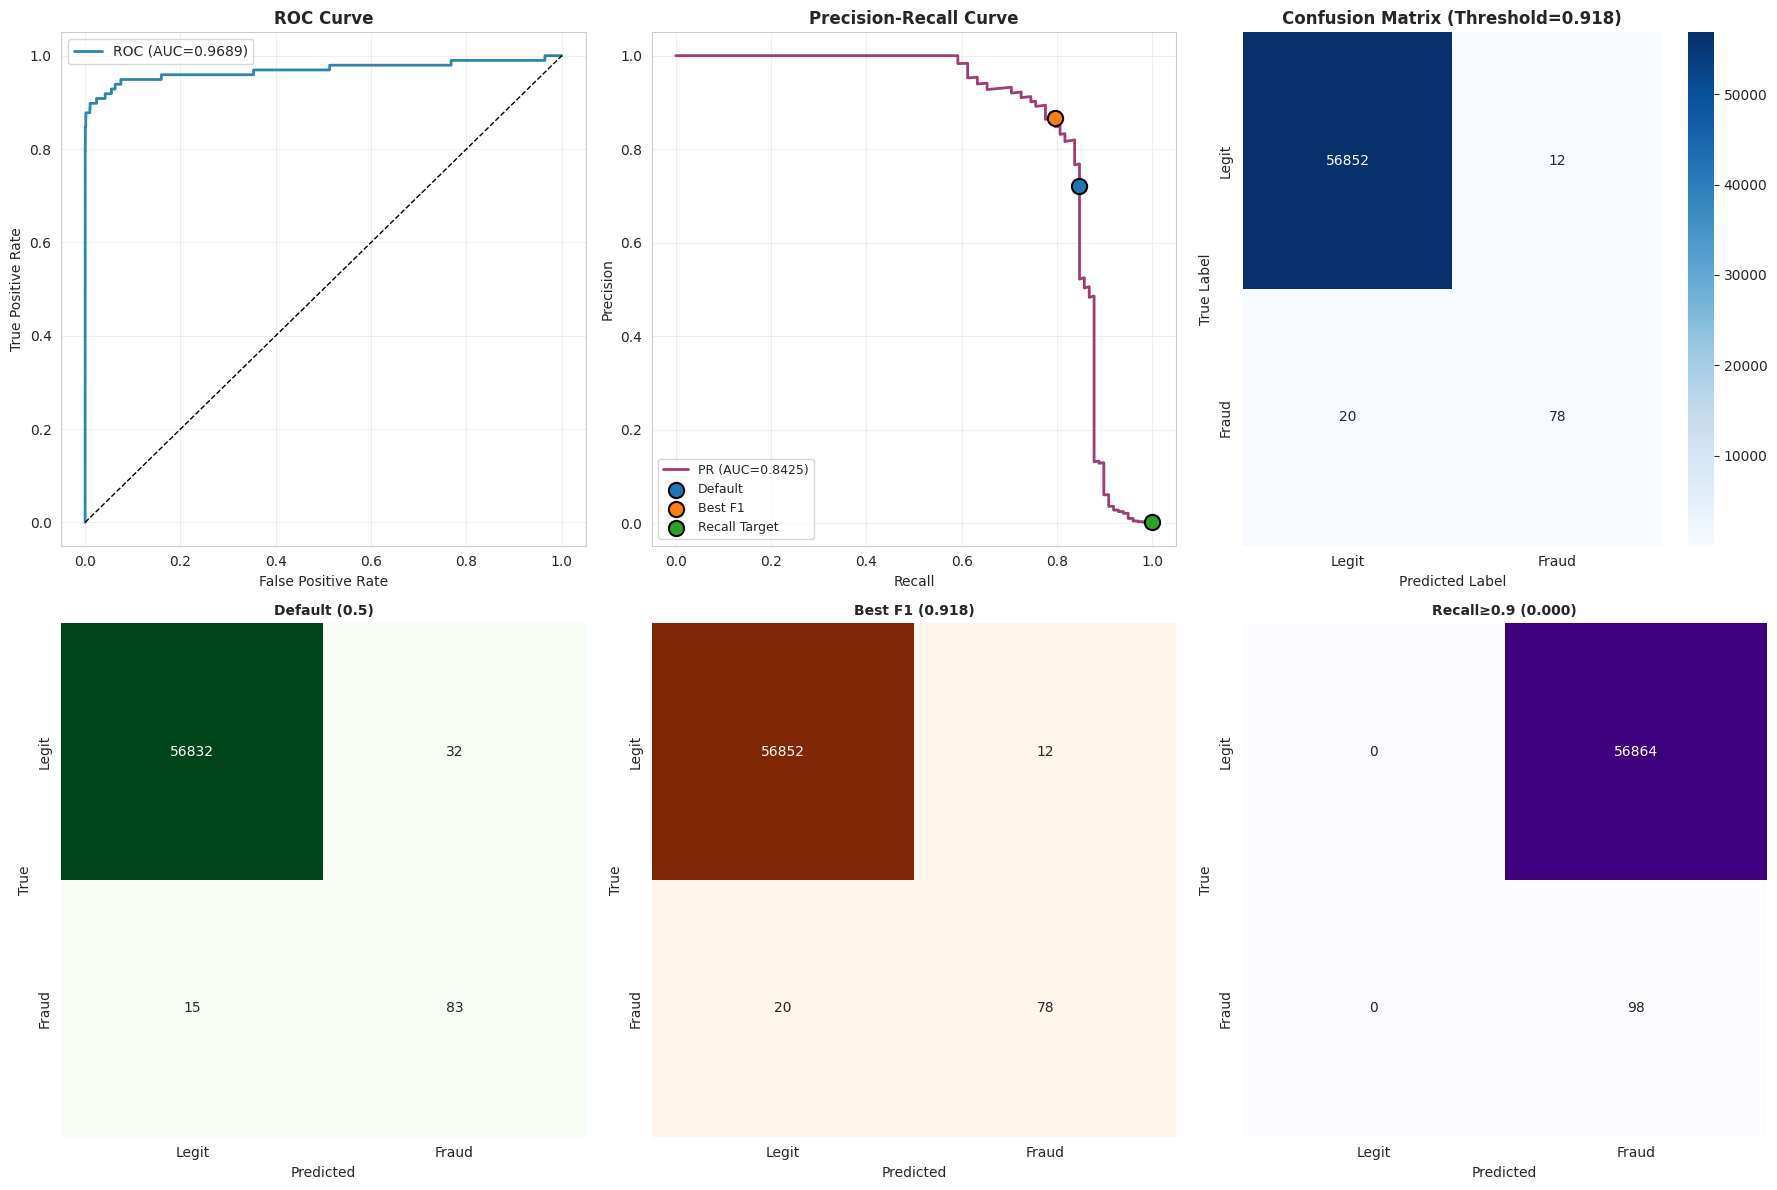

✓ Saved: feature_importance.png


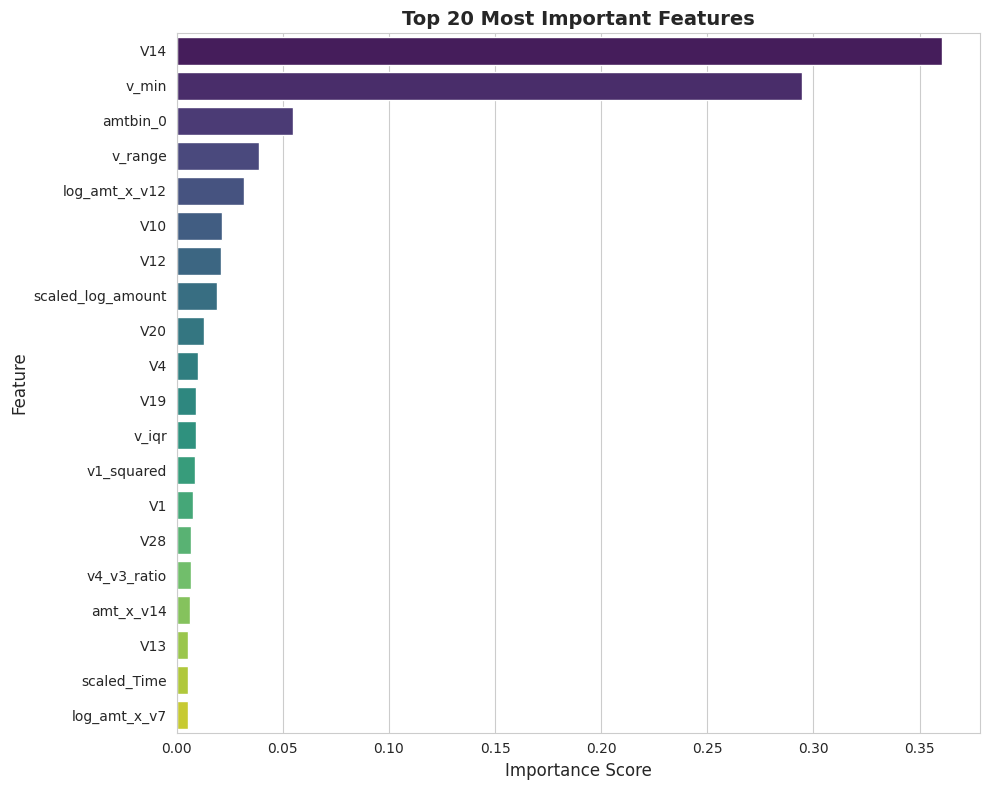

✓ Saved: threshold_analysis.png


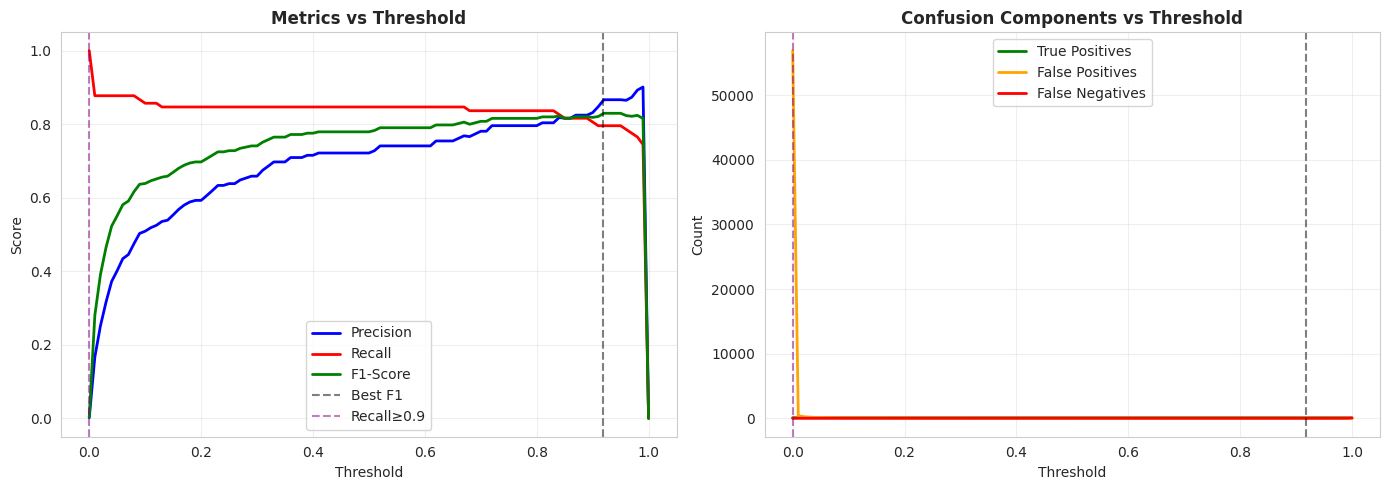


Generating additional bar charts...
✓ Saved: metrics_comparison_bars.png


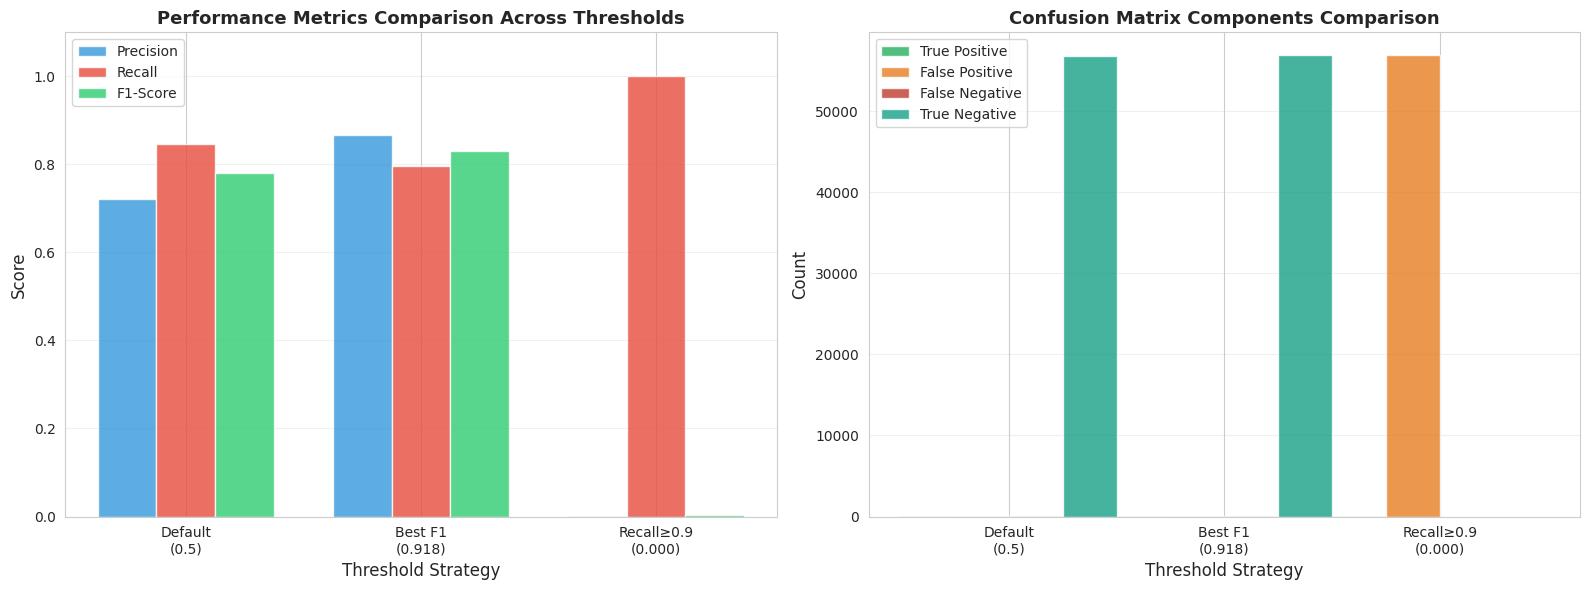

✓ Saved: class_distribution_smote.png


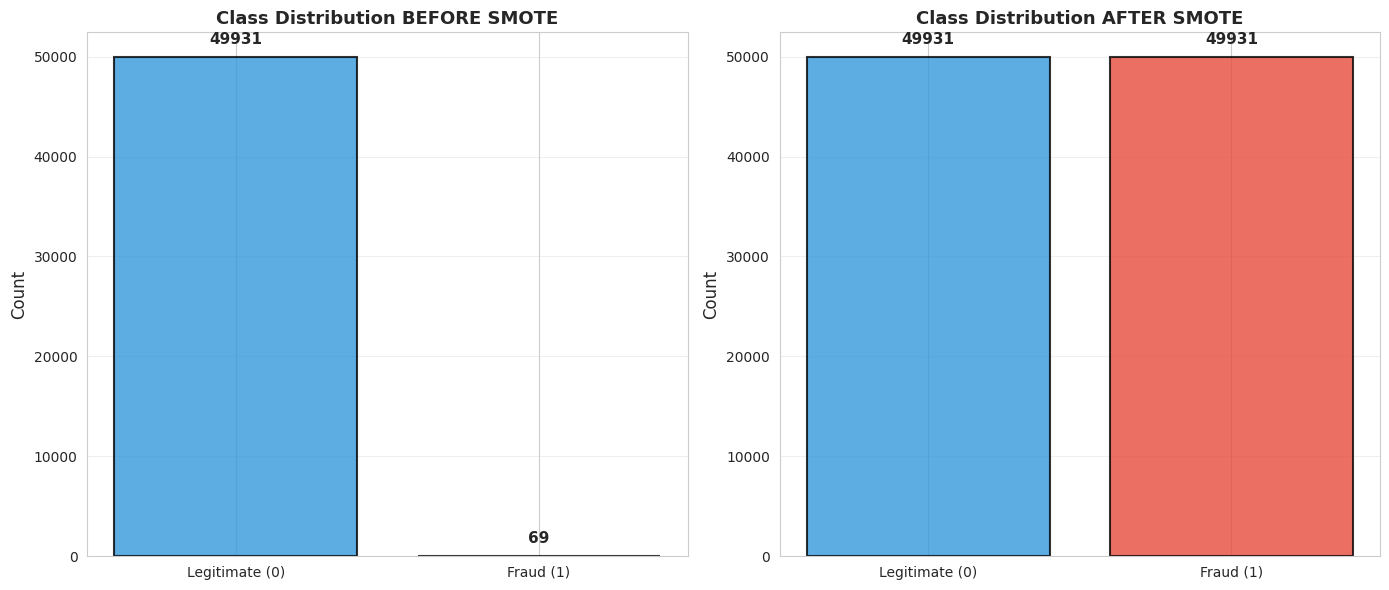

✓ Saved: error_analysis_bars.png


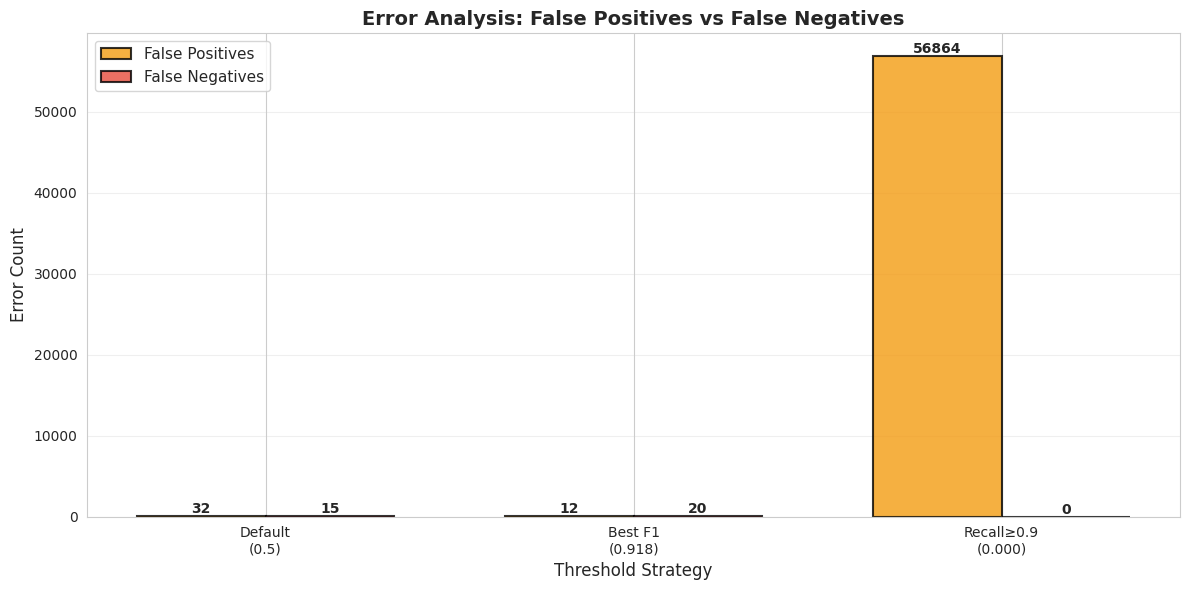

✓ Saved: top_features_horizontal.png


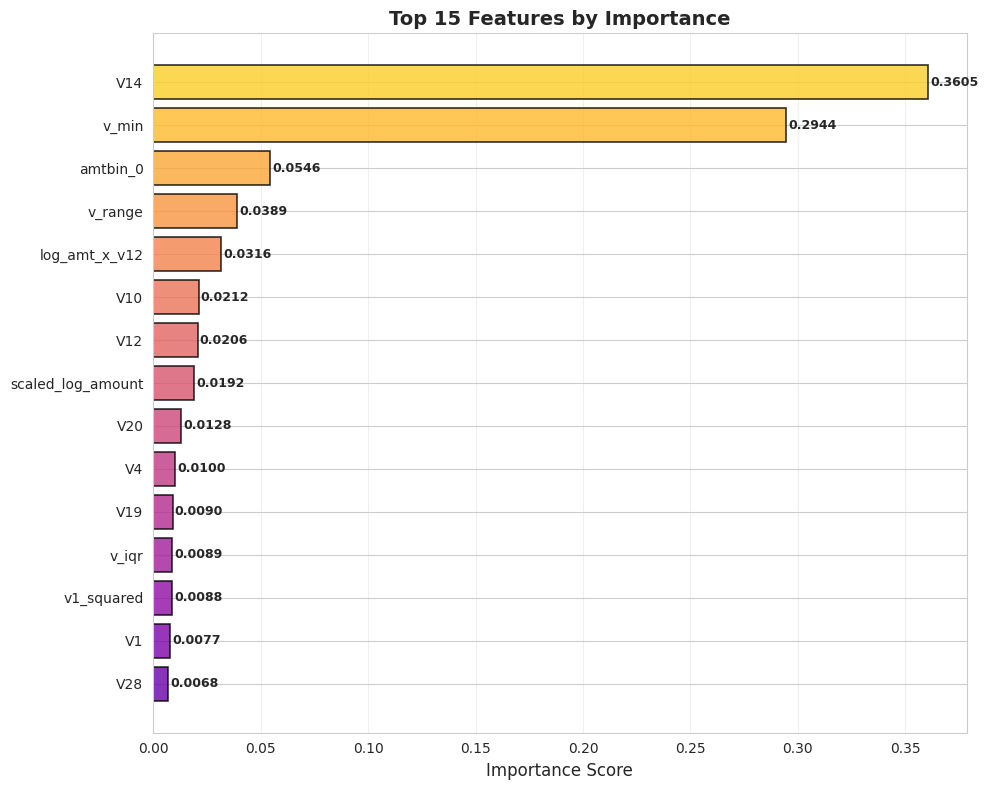

✓ Saved: model_performance_summary.png


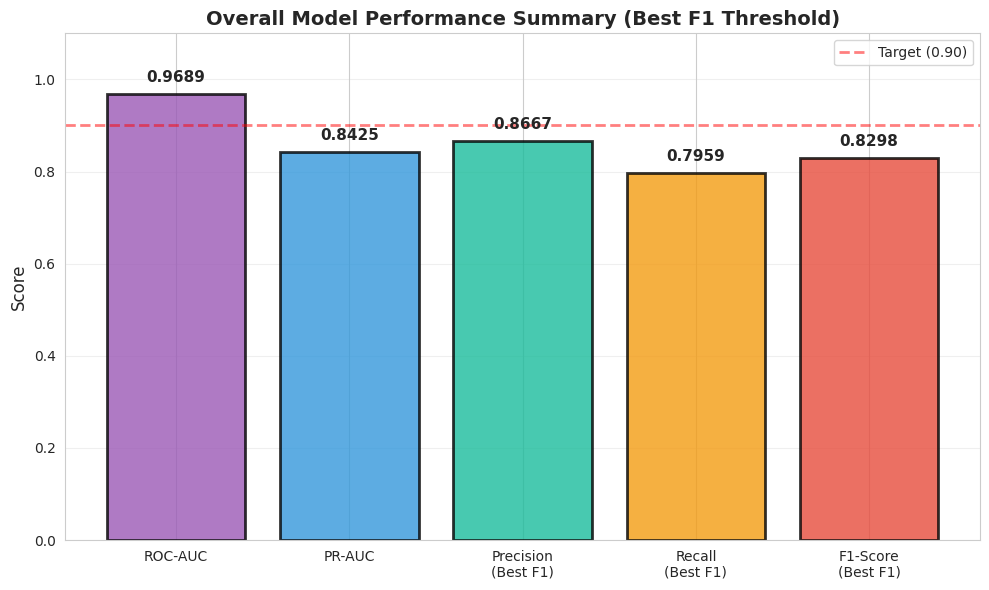


✅ PIPELINE COMPLETE!
ROC-AUC: 0.9689
PR-AUC: 0.8425
Best F1 threshold: 0.9180 (F1=0.8298)
Recall≥0.9 threshold: 0.0000
Features: 45
Training time: 5.25s

🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬
        LIVE FRAUD DETECTION DEMONSTRATION
🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬


════════════════════════════════════════════════════════════════════════════════
CASE 1: HIGH CONFIDENCE FRAUD
════════════════════════════════════════════════════════════════════════════════

📋 Transaction ID: 252774
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🎯 FRAUD PROBABILITY: 99.99%

   0%  [███████████████████████████████████████████████████████████░] 100%
                                                                  ↑
                                                                100.0%

🤖 MODEL DECISION:
   ╔═══════════════════════════════╗
   ║   🚨 FRAUD DETECTED! 🚨       ║
   ║   Block Transaction           ║
   ╚═══════════════════════════════╝

📊 ACTUAL LABEL: 🚨 FRAUD

   ✨ ✨ ✨ C

In [ ]:

# Complete End-to-End Credit Card Fraud Detection Pipeline
# Dataset: Kaggle creditcard.csv


#==============================================================================
# CONFIGURATION FLAGS
#==============================================================================
do_feature_selection = True
desired_recall = 0.90
smote_sample_limit = 50000

#==============================================================================
# 1. SETUP & INSTALLATION
#==============================================================================
print("=" * 80)
print("Installing packages...")
print("=" * 80)

!pip install -q pandas numpy scikit-learn matplotlib seaborn xgboost imbalanced-learn joblib

import os
import zipfile
import warnings
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    average_precision_score, roc_curve, precision_recall_curve,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import joblib

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
print("\n✓ Packages imported!\n")

#==============================================================================
# 2. LOAD DATASET (creditcard.csv.zip)
#==============================================================================
print("=" * 80)
print("Locating dataset...")
print("=" * 80)

csv_path = None

# Check for any ZIP files (including creditcard.csv.zip)
zip_files = [f for f in os.listdir('/content') if f.endswith('.zip')]
if zip_files:
    zip_path = f'/content/{zip_files[0]}'
    print(f"Found ZIP: {zip_path}")
    print("Extracting...")

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/extracted')

    # Search for creditcard.csv in extracted files
    for root, dirs, files in os.walk('/content/extracted'):
        for file in files:
            if 'creditcard' in file.lower() and file.lower().endswith('.csv'):
                csv_path = os.path.join(root, file)
                print(f"Found: {csv_path}")
                break
        if csv_path:
            break

# Check for direct CSV upload
if not csv_path and os.path.exists('/content/creditcard.csv'):
    csv_path = '/content/creditcard.csv'
    print(f"Found direct CSV: {csv_path}")

# If still not found
if not csv_path:
    print("Dataset not found. Please upload creditcard.csv")
    from google.colab import files
    uploaded = files.upload()
    if 'creditcard.csv' in uploaded:
        csv_path = '/content/creditcard.csv'
        print(f"Uploaded: {csv_path}")
    else:
        raise FileNotFoundError("creditcard.csv not found!")

print(f"\n Using dataset: {csv_path}\n")

#==============================================================================
# 3. LOAD & CLEAN DATA
#==============================================================================
print("=" * 80)
print("Loading and cleaning...")
print("=" * 80)

df = pd.read_csv(csv_path)
print(f"Shape: {df.shape}")

y_col = 'Class'
feature_cols = [col for col in df.columns if col != y_col]

# Coerce to numeric and fill NaNs
for col in feature_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df[feature_cols] = df[feature_cols].fillna(0.0)
df[y_col] = df[y_col].astype(int)

print(f"Class distribution:\n{df[y_col].value_counts()}\n")

#==============================================================================
# 4. FEATURE ENGINEERING
#==============================================================================
print("=" * 80)
print("Engineering features...")
print("=" * 80)

# Amount features
df['log_amount'] = np.log1p(np.abs(df['Amount']))
df['sqrt_amount'] = np.sqrt(np.abs(df['Amount']))
df['amount_squared'] = df['Amount'] ** 2

# Amount bins - Fixed: 9 bins need 9 labels (0-8)
bins = [-1, 1, 10, 50, 100, 300, 500, 1000, 10000, df['Amount'].max() + 1]
df['amount_bin'] = pd.cut(df['Amount'], bins=bins, labels=range(9)).astype(int)

# Time features
df['hour'] = (df['Time'] / 3600) % 24
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['time_of_day'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24], labels=[0, 1, 2, 3], include_lowest=True).astype(int)

# V-feature aggregates
v_cols = [col for col in df.columns if col.startswith('V') and col[1:].isdigit()]
if len(v_cols) > 0:
    df['v_sum'] = df[v_cols].sum(axis=1)
    df['v_mean'] = df[v_cols].mean(axis=1)
    df['v_std'] = df[v_cols].std(axis=1)
    df['v_abs_mean'] = df[v_cols].abs().mean(axis=1)
    df['v_median'] = df[v_cols].median(axis=1)
    df['v_skew_row'] = df[v_cols].skew(axis=1)
    df['v_kurt_row'] = df[v_cols].kurt(axis=1)
    df['v_min'] = df[v_cols].min(axis=1)
    df['v_max'] = df[v_cols].max(axis=1)
    df['v_range'] = df['v_max'] - df['v_min']
    df['v_positive_count'] = (df[v_cols] > 0).sum(axis=1)
    df['v_negative_count'] = (df[v_cols] < 0).sum(axis=1)
    df['v_q1'] = df[v_cols].quantile(0.25, axis=1)
    df['v_q3'] = df[v_cols].quantile(0.75, axis=1)
    df['v_iqr'] = df['v_q3'] - df['v_q1']

# Interactions
for v_feat in ['V1', 'V2', 'V3', 'V4', 'V7', 'V10', 'V12', 'V14', 'V17']:
    if v_feat in df.columns:
        df[f'amt_x_{v_feat.lower()}'] = df['Amount'] * df[v_feat]
        df[f'log_amt_x_{v_feat.lower()}'] = df['log_amount'] * df[v_feat]

# Ratios
if 'V2' in df.columns and 'V1' in df.columns:
    df['v2_v1_ratio'] = df['V2'] / (df['V1'].abs() + 1e-6)
if 'V4' in df.columns and 'V3' in df.columns:
    df['v4_v3_ratio'] = df['V4'] / (df['V3'].abs() + 1e-6)

# Polynomials
for v_feat in ['V1', 'V2', 'V3', 'V4', 'V7', 'V10']:
    if v_feat in df.columns:
        df[f'{v_feat.lower()}_squared'] = df[v_feat] ** 2

# One-hot encode
df = pd.concat([df, pd.get_dummies(df['amount_bin'], prefix='amtbin'),
                pd.get_dummies(df['time_of_day'], prefix='tod')], axis=1)

print(f"✓ New shape: {df.shape}\n")

#==============================================================================
# 5. SCALING
#==============================================================================
print("Scaling with RobustScaler...")
scaler = RobustScaler()

for feat in ['log_amount', 'sqrt_amount', 'amount_squared', 'Time', 'hour']:
    if feat in df.columns:
        df[f'scaled_{feat}'] = scaler.fit_transform(df[[feat]])

df = df.drop(columns=['Amount', 'Time', 'log_amount', 'sqrt_amount', 'amount_squared',
                      'amount_bin', 'time_of_day', 'hour'], errors='ignore')

cols = [col for col in df.columns if col != y_col] + [y_col]
df = df[cols]
print(f"✓ Final shape: {df.shape}\n")

#==============================================================================
# 6. TRAIN/TEST SPLIT
#==============================================================================
print("=" * 80)
print("Splitting data...")
print("=" * 80)

X = df.drop(columns=[y_col])
y = df[y_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Train: {X_train.shape}, Test: {X_test.shape}\n")

#==============================================================================
# 7. FEATURE SELECTION
#==============================================================================
if do_feature_selection:
    print("Feature selection enabled...")
    if len(X_train) > smote_sample_limit:
        sample_idx = np.random.choice(len(X_train), smote_sample_limit, replace=False)
        X_fs, y_fs = X_train.iloc[sample_idx], y_train.iloc[sample_idx]
    else:
        X_fs, y_fs = X_train, y_train

    xgb_fs = XGBClassifier(n_estimators=50, max_depth=4, learning_rate=0.1,
                          use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
    xgb_fs.fit(X_fs, y_fs)

    selector = SelectFromModel(xgb_fs, threshold='median', prefit=True)
    X_train = selector.transform(X_train)
    X_test = selector.transform(X_test)
    selected_features = X.columns[selector.get_support()].tolist()
    print(f"✓ Selected {len(selected_features)} features\n")
else:
    selected_features = X.columns.tolist()

X_train = pd.DataFrame(X_train, columns=selected_features)
X_test = pd.DataFrame(X_test, columns=selected_features)

#==============================================================================
# 8. SMOTE
#==============================================================================
print("=" * 80)
print("Applying SMOTE...")
print("=" * 80)

if len(X_train) > smote_sample_limit:
    sample_idx = np.random.choice(len(X_train), smote_sample_limit, replace=False)
    X_train, y_train = X_train.iloc[sample_idx], y_train.iloc[sample_idx]

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(f"After SMOTE: {pd.Series(y_train_res).value_counts().to_dict()}\n")

#==============================================================================
# 9. TRAIN MODEL
#==============================================================================
print("=" * 80)
print("Training XGBoost...")
print("=" * 80)

model = XGBClassifier(
    n_estimators=300, max_depth=7, learning_rate=0.03, min_child_weight=5,
    subsample=0.8, colsample_bytree=0.8, gamma=0.1, reg_alpha=0.1, reg_lambda=1.0,
    use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1
)

start_time = time.time()
model.fit(X_train_res, y_train_res)
training_time = time.time() - start_time
print(f"✓ Training complete in {training_time:.2f}s\n")

#==============================================================================
# 10. PREDICTIONS & METRICS
#==============================================================================
print("=" * 80)
print("Evaluating model...")
print("=" * 80)

y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred_default = (y_pred_proba >= 0.5).astype(int)

print("Classification Report (threshold=0.5):")
print(classification_report(y_test, y_pred_default))

roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)
print(f"\nROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}\n")

#==============================================================================
# 11. THRESHOLD TUNING
#==============================================================================
print("Optimizing threshold...")
thresholds = np.linspace(0, 1, 501)
best_f1, best_f1_thresh, recall_target_thresh = 0, 0.5, 0.5

for thresh in thresholds:
    y_pred_temp = (y_pred_proba >= thresh).astype(int)
    if y_pred_temp.sum() == 0:
        continue
    f1 = f1_score(y_test, y_pred_temp, zero_division=0)
    rec = recall_score(y_test, y_pred_temp, zero_division=0)
    if f1 > best_f1:
        best_f1, best_f1_thresh = f1, thresh
    if rec >= desired_recall and (recall_target_thresh == 0.5 or thresh < recall_target_thresh):
        recall_target_thresh = thresh

print(f"✓ Best F1: {best_f1_thresh:.4f} (F1={best_f1:.4f})")
print(f"✓ Recall≥{desired_recall}: {recall_target_thresh:.4f}\n")

def compute_metrics(thresh):
    y_pred = (y_pred_proba >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return {
        'threshold': thresh,
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc, 'pr_auc': pr_auc,
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
    }

metrics_default = compute_metrics(0.5)
metrics_best_f1 = compute_metrics(best_f1_thresh)
metrics_recall_target = compute_metrics(recall_target_thresh)

summary_df = pd.DataFrame([metrics_default, metrics_best_f1, metrics_recall_target])
summary_df.index = ['Default (0.5)', f'Best F1 ({best_f1_thresh:.4f})', f'Recall≥{desired_recall} ({recall_target_thresh:.4f})']

print("Threshold Comparison:")
print(summary_df.to_string())
print()

#==============================================================================
# 12. VISUALIZATIONS
#==============================================================================
print("=" * 80)
print("Generating plots...")
print("=" * 80)

fig = plt.figure(figsize=(18, 12))

# ROC Curve
plt.subplot(2, 3, 1)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.4f})', linewidth=2, color='#2E86AB')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# PR Curve
plt.subplot(2, 3, 2)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall_curve, precision_curve, label=f'PR (AUC={pr_auc:.4f})', linewidth=2, color='#A23B72')
for idx, (name, m) in enumerate([('Default', metrics_default), ('Best F1', metrics_best_f1), ('Recall Target', metrics_recall_target)]):
    plt.scatter(m['recall'], m['precision'], s=120, zorder=5, label=name, edgecolors='black', linewidth=1.5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve', fontweight='bold')
plt.legend(fontsize=9)
plt.grid(alpha=0.3)

# Confusion Matrix (Best F1)
plt.subplot(2, 3, 3)
y_pred_best = (y_pred_proba >= best_f1_thresh).astype(int)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title(f'Confusion Matrix (Threshold={best_f1_thresh:.3f})', fontweight='bold')

# 3 Confusion Matrices
for idx, (title, thresh, cmap) in enumerate([(f'Default (0.5)', 0.5, 'Greens'),
                                               (f'Best F1 ({best_f1_thresh:.3f})', best_f1_thresh, 'Oranges'),
                                               (f'Recall≥{desired_recall} ({recall_target_thresh:.3f})', recall_target_thresh, 'Purples')]):
    plt.subplot(2, 3, 4 + idx)
    y_p = (y_pred_proba >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_p)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False, xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.title(title, fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('comprehensive_evaluation.png', dpi=200, bbox_inches='tight')
print("✓ Saved: comprehensive_evaluation.png")
plt.show()

# Feature Importance
fig, ax = plt.subplots(figsize=(10, 8))
importance_df = pd.DataFrame({'feature': selected_features, 'importance': model.feature_importances_}).sort_values('importance', ascending=False).head(20)
sns.barplot(data=importance_df, y='feature', x='importance', palette='viridis', ax=ax)
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Top 20 Most Important Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
print("✓ Saved: feature_importance.png")
plt.show()

# Threshold Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
thresh_range = np.linspace(0, 1, 101)
precisions, recalls, f1_scores = [], [], []

for t in thresh_range:
    y_p = (y_pred_proba >= t).astype(int)
    if y_p.sum() > 0:
        precisions.append(precision_score(y_test, y_p, zero_division=0))
        recalls.append(recall_score(y_test, y_p, zero_division=0))
        f1_scores.append(f1_score(y_test, y_p, zero_division=0))
    else:
        precisions.append(0)
        recalls.append(0)
        f1_scores.append(0)

axes[0].plot(thresh_range, precisions, label='Precision', linewidth=2, color='blue')
axes[0].plot(thresh_range, recalls, label='Recall', linewidth=2, color='red')
axes[0].plot(thresh_range, f1_scores, label='F1-Score', linewidth=2, color='green')
axes[0].axvline(best_f1_thresh, color='black', linestyle='--', alpha=0.5, label='Best F1')
axes[0].axvline(recall_target_thresh, color='purple', linestyle='--', alpha=0.5, label=f'Recall≥{desired_recall}')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('Metrics vs Threshold', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

tps, fps, fns = [], [], []
for t in thresh_range:
    y_p = (y_pred_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_p).ravel()
    tps.append(tp)
    fps.append(fp)
    fns.append(fn)

axes[1].plot(thresh_range, tps, label='True Positives', linewidth=2, color='green')
axes[1].plot(thresh_range, fps, label='False Positives', linewidth=2, color='orange')
axes[1].plot(thresh_range, fns, label='False Negatives', linewidth=2, color='red')
axes[1].axvline(best_f1_thresh, color='black', linestyle='--', alpha=0.5)
axes[1].axvline(recall_target_thresh, color='purple', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Count')
axes[1].set_title('Confusion Components vs Threshold', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('threshold_analysis.png', dpi=150, bbox_inches='tight')
print("✓ Saved: threshold_analysis.png")
plt.show()

#==============================================================================
# 13. ADDITIONAL BAR CHARTS
#==============================================================================
print("\nGenerating additional bar charts...")

# Bar Chart 1: Model Performance Comparison Across Thresholds
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Metrics comparison
metrics_names = ['Precision', 'Recall', 'F1-Score']
thresholds_names = ['Default\n(0.5)', f'Best F1\n({best_f1_thresh:.3f})', f'Recall≥{desired_recall}\n({recall_target_thresh:.3f})']

precision_vals = [metrics_default['precision'], metrics_best_f1['precision'], metrics_recall_target['precision']]
recall_vals = [metrics_default['recall'], metrics_best_f1['recall'], metrics_recall_target['recall']]
f1_vals = [metrics_default['f1'], metrics_best_f1['f1'], metrics_recall_target['f1']]

x = np.arange(len(thresholds_names))
width = 0.25

axes[0].bar(x - width, precision_vals, width, label='Precision', color='#3498db', alpha=0.8)
axes[0].bar(x, recall_vals, width, label='Recall', color='#e74c3c', alpha=0.8)
axes[0].bar(x + width, f1_vals, width, label='F1-Score', color='#2ecc71', alpha=0.8)
axes[0].set_xlabel('Threshold Strategy', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Performance Metrics Comparison Across Thresholds', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(thresholds_names)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.1])

# Confusion Matrix Components comparison
tp_vals = [metrics_default['tp'], metrics_best_f1['tp'], metrics_recall_target['tp']]
fp_vals = [metrics_default['fp'], metrics_best_f1['fp'], metrics_recall_target['fp']]
tn_vals = [metrics_default['tn'], metrics_best_f1['tn'], metrics_recall_target['tn']]
fn_vals = [metrics_default['fn'], metrics_best_f1['fn'], metrics_recall_target['fn']]

axes[1].bar(x - 1.5*width, tp_vals, width, label='True Positive', color='#27ae60', alpha=0.8)
axes[1].bar(x - 0.5*width, fp_vals, width, label='False Positive', color='#e67e22', alpha=0.8)
axes[1].bar(x + 0.5*width, fn_vals, width, label='False Negative', color='#c0392b', alpha=0.8)
axes[1].bar(x + 1.5*width, tn_vals, width, label='True Negative', color='#16a085', alpha=0.8)
axes[1].set_xlabel('Threshold Strategy', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Confusion Matrix Components Comparison', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(thresholds_names)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('metrics_comparison_bars.png', dpi=150, bbox_inches='tight')
print("✓ Saved: metrics_comparison_bars.png")
plt.show()

# Bar Chart 2: Class Distribution Before/After SMOTE
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Before SMOTE
class_counts_before = y_train.value_counts().sort_index()
axes[0].bar(['Legitimate (0)', 'Fraud (1)'], class_counts_before.values,
            color=['#3498db', '#e74c3c'], alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Class Distribution BEFORE SMOTE', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts_before.values):
    axes[0].text(i, v + max(class_counts_before.values)*0.02, str(v),
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# After SMOTE
class_counts_after = pd.Series(y_train_res).value_counts().sort_index()
axes[1].bar(['Legitimate (0)', 'Fraud (1)'], class_counts_after.values,
            color=['#3498db', '#e74c3c'], alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Class Distribution AFTER SMOTE', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts_after.values):
    axes[1].text(i, v + max(class_counts_after.values)*0.02, str(v),
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution_smote.png', dpi=150, bbox_inches='tight')
print("✓ Saved: class_distribution_smote.png")
plt.show()

# Bar Chart 3: Error Analysis (FP vs FN across thresholds)
fig, ax = plt.subplots(figsize=(12, 6))

error_data = pd.DataFrame({
    'Threshold': thresholds_names,
    'False Positives': fp_vals,
    'False Negatives': fn_vals
})

x = np.arange(len(thresholds_names))
width = 0.35

bars1 = ax.bar(x - width/2, error_data['False Positives'], width,
               label='False Positives', color='#f39c12', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, error_data['False Negatives'], width,
               label='False Negatives', color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Threshold Strategy', fontsize=12)
ax.set_ylabel('Error Count', fontsize=12)
ax.set_title('Error Analysis: False Positives vs False Negatives', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(thresholds_names)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('error_analysis_bars.png', dpi=150, bbox_inches='tight')
print("✓ Saved: error_analysis_bars.png")
plt.show()

# Bar Chart 4: Top 15 Features by Importance (Horizontal)
fig, ax = plt.subplots(figsize=(10, 8))
top_features = importance_df.head(15).sort_values('importance', ascending=True)

colors = plt.cm.plasma(np.linspace(0.2, 0.9, len(top_features)))
bars = ax.barh(range(len(top_features)), top_features['importance'],
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'], fontsize=10)
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Top 15 Features by Importance', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top_features.iterrows()):
    ax.text(row['importance'] + 0.001, i, f"{row['importance']:.4f}",
            va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('top_features_horizontal.png', dpi=150, bbox_inches='tight')
print("✓ Saved: top_features_horizontal.png")
plt.show()

# Bar Chart 5: Model Performance Summary (All Key Metrics)
fig, ax = plt.subplots(figsize=(10, 6))

metric_names = ['ROC-AUC', 'PR-AUC', 'Precision\n(Best F1)', 'Recall\n(Best F1)', 'F1-Score\n(Best F1)']
metric_values = [roc_auc, pr_auc, metrics_best_f1['precision'], metrics_best_f1['recall'], metrics_best_f1['f1']]

colors_palette = ['#9b59b6', '#3498db', '#1abc9c', '#f39c12', '#e74c3c']
bars = ax.bar(metric_names, metric_values, color=colors_palette, alpha=0.8,
              edgecolor='black', linewidth=2)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Overall Model Performance Summary (Best F1 Threshold)', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars, metric_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{val:.4f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add a horizontal line at 0.9 for reference
ax.axhline(y=0.9, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Target (0.90)')
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig('model_performance_summary.png', dpi=150, bbox_inches='tight')
print("✓ Saved: model_performance_summary.png")
plt.show()

#==============================================================================
# SUMMARY
#==============================================================================
print("\n" + "=" * 80)
print("✅ PIPELINE COMPLETE!")
print("=" * 80)
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"Best F1 threshold: {best_f1_thresh:.4f} (F1={best_f1:.4f})")
print(f"Recall≥{desired_recall} threshold: {recall_target_thresh:.4f}")
print(f"Features: {len(selected_features)}")
print(f"Training time: {training_time:.2f}s")

################################################################################
# SIMPLE LIVE DEMO - Add this after your model training is complete
# Just copy-paste this at the end of your main script
################################################################################


print("        LIVE FRAUD DETECTION DEMONSTRATION")

# Get all predictions for test set
all_probs = model.predict_proba(X_test)[:, 1]

# Find interesting cases using position-based indexing
fraud_positions = y_test[y_test == 1].index.tolist()
legit_positions = y_test[y_test == 0].index.tolist()

# Get actual indices (not positions)
demo_cases = []

# Case 1: High confidence fraud
if len(fraud_positions) > 0:
    fraud_probs_list = [(i, all_probs[y_test.index.get_loc(i)]) for i in fraud_positions]
    high_fraud = max(fraud_probs_list, key=lambda x: x[1])
    demo_cases.append(("HIGH CONFIDENCE FRAUD", high_fraud[0]))

# Case 2: Medium fraud
if len(fraud_positions) > 5:
    fraud_probs_list.sort(key=lambda x: x[1])
    mid_fraud = fraud_probs_list[len(fraud_probs_list)//2]
    demo_cases.append(("MEDIUM CONFIDENCE FRAUD", mid_fraud[0]))

# Case 3: Borderline case
all_diffs = [(i, abs(all_probs[y_test.index.get_loc(i)] - best_f1_thresh)) for i in y_test.index]
borderline = min(all_diffs, key=lambda x: x[1])
demo_cases.append(("BORDERLINE CASE", borderline[0]))

# Case 4: Safe legitimate
if len(legit_positions) > 0:
    legit_probs_list = [(i, all_probs[y_test.index.get_loc(i)]) for i in legit_positions]
    safe_legit = min(legit_probs_list, key=lambda x: x[1])
    demo_cases.append(("SAFE LEGITIMATE", safe_legit[0]))

# Display each case
for case_num, (case_name, trans_id) in enumerate(demo_cases, 1):
    print("\n" + "═" * 80)
    print(f"CASE {case_num}: {case_name}")
    print("═" * 80)

    # Get the position in the test set
    position = y_test.index.get_loc(trans_id)

    # Get prediction
    true_label = y_test.iloc[position]
    fraud_prob = all_probs[position]
    prediction = 1 if fraud_prob >= best_f1_thresh else 0

    # Display
    print(f"\n Transaction ID: {trans_id}")
    print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")

    print(f"\n FRAUD PROBABILITY: {fraud_prob*100:.2f}%\n")

    # Visual meter
    meter_length = 60
    filled = int(fraud_prob * meter_length)

    print(f"   0%  [{('█' * filled).ljust(meter_length, '░')}] 100%")
    print(f"        {' ' * max(0, filled - 1)}↑")
    print(f"        {' ' * max(0, filled - 3)}{fraud_prob*100:.1f}%")

    # Decision
    print(f"\n MODEL DECISION:")
    if prediction == 1:
        print(f"   ╔═══════════════════════════════╗")
        print(f"   ║        FRAUD DETECTED!        ║")
        print(f"   ║       Block Transaction       ║")
        print(f"   ╚═══════════════════════════════╝")
    else:
        print(f"   ╔═══════════════════════════════╗")
        print(f"   ║     LEGITIMATE TRANSACTION    ║")
        print(f"   ║            Approve            ║")
        print(f"   ╚═══════════════════════════════╝")

    # Ground truth
    print(f"\n ACTUAL LABEL: {'FRAUD' if true_label == 1 else 'LEGITIMATE'}")

    # Result
    if prediction == true_label:
        print(f"\n  CORRECT PREDICTION! ")
    else:
        error_type = "False Positive" if prediction == 1 else "False Negative"
        print(f"\n  INCORRECT: {error_type}")

################################################################################
# QUICK TEST FUNCTION
################################################################################

print("\n\n")
print("      QUICK TEST: Random Sample Predictions")
print( "\n")

# Test 5 random transactions
num_samples = min(5, len(y_test))
random_positions = np.random.choice(len(y_test), num_samples, replace=False)

for i, pos in enumerate(random_positions, 1):
    trans_id = y_test.index[pos]
    true_label = y_test.iloc[pos]
    fraud_prob = all_probs[pos]
    prediction = 1 if fraud_prob >= best_f1_thresh else 0

    print(f"\n{'─'*60}")
    print(f"SAMPLE {i}: Transaction #{trans_id}")
    print(f"{'─'*60}")
    print(f"  Actual:      {'FRAUD' if true_label == 1 else ' LEGITIMATE'}")
    print(f"  Probability: {fraud_prob:.4f} ({fraud_prob*100:.1f}%)")
    print(f"  Prediction:  {'FRAUD' if prediction == 1 else 'LEGITIMATE'}")
    print(f"  Result:      {'CORRECT' if prediction == true_label else ' WRONG'}")

################################################################################
# SUMMARY STATISTICS
################################################################################

print("\n\n" + "╔" + "═" * 78 + "╗")
print("║" + " " * 20 + "FINAL PERFORMANCE SUMMARY" + " " * 29 + "║")
print("╚" + "═" * 78 + "╝\n")

y_pred_all = (all_probs >= best_f1_thresh).astype(int)
accuracy = (y_pred_all == y_test.values).mean()

total_frauds = y_test.sum()
total_legit = (y_test == 0).sum()

print(f"   Overall Accuracy: {accuracy*100:.2f}%")
print(f"   Frauds Detected: {metrics_best_f1['tp']}/{total_frauds} ({metrics_best_f1['recall']*100:.1f}%)")
print(f"   False Alarms: {metrics_best_f1['fp']} ({metrics_best_f1['fp']/total_legit*100:.2f}% of legitimate)")
print(f"   Missed Frauds: {metrics_best_f1['fn']}")
print(f"   Precision: {metrics_best_f1['precision']*100:.2f}%")
print(f"   Recall: {metrics_best_f1['recall']*100:.2f}%")
print(f"   F1-Score: {metrics_best_f1['f1']*100:.2f}%")
print(f"   ROC-AUC: {roc_auc:.4f}")
print(f"   PR-AUC: {pr_auc:.4f}")

print("\n" + "═" * 80)
print("DEMONSTRATION COMPLETE!")
print("═" * 80 + "\n")

################################################################################
# INTERACTIVE TEST FUNCTION (Use this to test specific transactions)
################################################################################

def test_transaction(show_n=5):
    """
    Show predictions for n random transactions
    Usage: test_transaction(10)  # Shows 10 random predictions
    """
    print(f"\n{'TESTING {show_n} RANDOM TRANSACTIONS ':^80}\n")

    positions = np.random.choice(len(y_test), min(show_n, len(y_test)), replace=False)

    for i, pos in enumerate(positions, 1):
        trans_id = y_test.index[pos]
        true_label = y_test.iloc[pos]
        fraud_prob = all_probs[pos]
        pred = 1 if fraud_prob >= best_f1_thresh else 0

        status = "✅" if pred == true_label else "❌"

        print(f"{i:2d}. ID:{trans_id:6d} | Prob:{fraud_prob:.3f} | "
              f"Pred:{'FRAUD' if pred else 'LEGIT':5s} | "
              f"True:{'FRAUD' if true_label else 'LEGIT':5s} | {status}")

    print()

# Run it automatically
test_transaction(20)
